### Develop a document clustering system.
First, collect a number of documents that belong to different categories, namely Sport, Health 
and Business. Each document should be at least one sentence (the longer is usually the better). 
The total number of documents is up to you but should be at least 100 (the more is usually the 
better). You may collect these document from publicly available web sites such as BBC news 
websites, but make sure you preserve their copyrights and terms of use and clearly cite them in 
your work. You may simply copy-paste such texts manually, and writing an RSS feed 
reader/crawler to do it automatically is NOT mandatory.
Once you have collected sufficient documents, cluster them using a standard clustering method 
(e.g. K-means).

Finally, use the created model to assign a new document to one of the existing clusters. That is, 
the user enters a document (e.g. a sentence) and your system outputs the right cluster.
NOTE: You must show in your report and viva that your system suggests the right cluster for variety 
of inputs, e.g. short and long inputs, those with and without stop worlds, inputs of different topics, 
as well as more challenging inputs to show the system is robust enough.

In [1]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
from scipy import interp

# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# ML Models
from sklearn.cluster import KMeans

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


## load datasets

Data can be loaded from kaggle and other online websites
https://www.kaggle.com/datasets/pariza/bbc-news-summary
https://huggingface.co/datasets/okite97/news-data/viewer/default/train?p={}

In [2]:
df = pd.read_csv("news_data.csv")
df.sample(5)

,Text,Category
156,"Murray, on the other hand, is 407th in the cur...",sport
77,Covid: Several Countries Reintroduce Restricti...,health
68,China’s Sinovac Covid Vaccine to Be Included i...,health
196,He says so himself in a matter-of-fact way as ...,sport
325,According to a statement from Mr Spitzer's off...,business


In [3]:
df.shape

(340, 2)

 Here , total dataset is 340

## Data Exploration

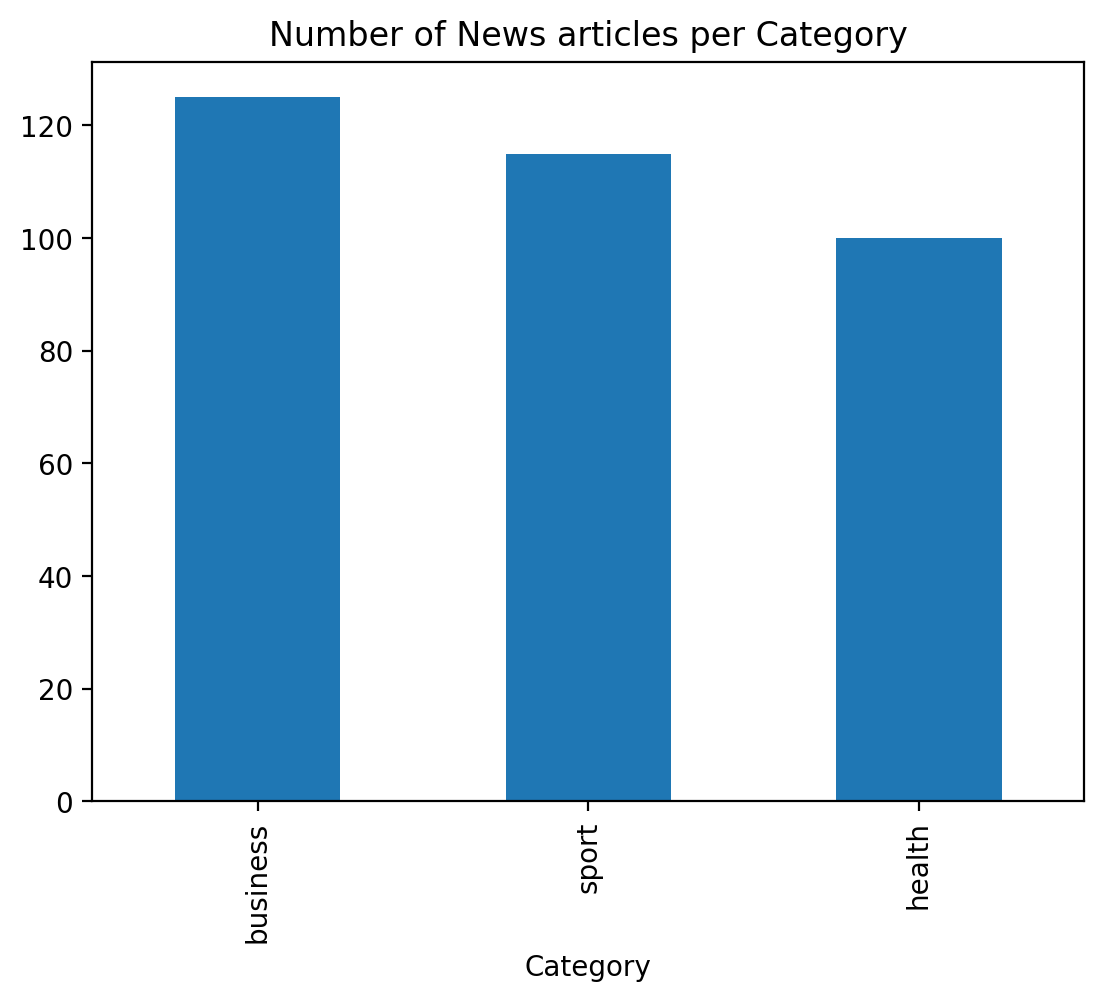

In [4]:
df['Category'].value_counts().plot(kind='bar')
plt.title('Number of News articles per Category');

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      340 non-null    object
 1   Category  340 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB


## Data pre-processing

In [6]:
def preprocess_text(text):
    """
    Preprocesses the input text by removing stopwords, special characters, digits, dots, 
    trailing underscores,and converting it to lowercase.

    Args:
    text (str): The input text to be preprocessed.

    Returns:
    str: The preprocessed text.
    """

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove special characters, digits, and dots
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\.', ' ', text)

    # Remove trailing underscores
    text = text.rsplit('_', 1)[0]

    # Convert to lowercase
    text = text.lower()

    return text


def get_wordnet_pos(word):
    """
    Maps POS tags to WordNet POS tags.

    Args:
    word (str): The word to get the POS tag for.

    Returns:
    str: The WordNet POS tag corresponding to the input word.
    """
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "N": wordnet.NOUN,
        "R": wordnet.ADV,
        "V": wordnet.VERB,
        "J": wordnet.ADJ
    }
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_text(text):
    """
    Lemmatizes the input text using WordNet lemmatizer.

    Args:
    text (str): The input text to be lemmatized.

    Returns:
    str: The lemmatized text.
    """
    tokens = word_tokenize(text)
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens
    ]
    return ' '.join(lemmatized_tokens)


def preprocess(df):
    """
    Applies preprocessing steps to a DataFrame containing a 'Text' column.

    Args:
    df (DataFrame): The DataFrame containing the 'Text' column to be preprocessed.

    Returns:
    DataFrame: The DataFrame with an additional 'filtered_Text' column containing the preprocessed text.
    """
    # Apply preprocessing steps
    df['filtered_Text'] = df['Text'].apply(preprocess_text)
    df['filtered_Text'] = df['filtered_Text'].apply(lemmatize_text)
    return df

In [7]:
filtered_df = preprocess(df)

In [8]:
## Data before pre-processing
filtered_df.iloc[1]['Text']

'Scientists have discovered a key defense mechanism that effectively blocks the majority of bird flu strains from invading our bodies. Bird flus have caused four pandemics since 1918, resulting in millions of deaths. Researchers from the University of Glasgow found that these pandemics, along with regular winter flus, have evolved strategies to bypass this natural defense barrier. The team believes that soon they will be able to predict which bird flu strains pose the greatest risk.\n\nThe scientists conducted investigations into spillover events, which occur when a person becomes infected by an animal. This cross-species transmission is a critical step in the emergence of a new pandemic. Through laboratory experiments, the researchers identified a specific section of our DNA called BTN3A3 that becomes activated in response to infection. BTN3A3 was found to be active in the nose, throat, and lungs, reducing the ability of bird flu strains to replicate.\n\nDr. Rute Maria Pinto, one of t

In [9]:
## Data after pre-processing
filtered_df.iloc[1]['filtered_Text']

'scientist discover key defense mechanism effectively block majority bird flu strain invade body bird flu cause four pandemic since result million death researcher university glasgow found pandemic along regular winter flu evolve strategy bypass natural defense barrier the team believe soon able predict bird flu strain pose great risk the scientist conduct investigation spillover event occur person becomes infect animal this cross specie transmission critical step emergence new pandemic through laboratory experiment researcher identify specific section dna call btna becomes activate response infection btna found active nose throat lung reduce ability bird flu strain replicate dr rute maria pinto one researcher state nearly all bird flu strain unable bypass protective mechanism therefore can not infect human however human virus include pandemic strain evolve resistance btna overcome defense barrier there ongoing risk bird flu strain cross human wild bird harbor various flu virus poultry

## Vectorize

In [10]:
def vectorizer(df,column_name):  
    """
    Vectorizes the text data in the specified column of the DataFrame using 
    either TF-IDF or Count Vectorization.

    Args:
    df (DataFrame): The DataFrame containing the text data.
    column_name (str): The name of the column containing the text data.

    Returns:
    tuple: A tuple containing the vectorizer used for transformation and the resulting 
    TF-IDF matrix or Count matrix.
    """
    tf_idf = True

    if tf_idf:
        # tfidf = TfidfVectorizer(stop_words='english')
        vectorizer = TfidfVectorizer(use_idf=True,  
                                smooth_idf=True,  
                                ngram_range=(1,1),stop_words='english')

        tfidf_matrix = vectorizer.fit_transform(df[column_name])
        
    else:
        
        vectorizer = CountVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df[column_name])
    return vectorizer,tfidf_matrix

In [11]:
vectorizer,tfidf_matrix = vectorizer(df=filtered_df,column_name='filtered_Text')

In [12]:
SSE = []
rang_cluster = range(1,10,1)
for cluster in rang_cluster:
    print(cluster)
    kmeans = KMeans(n_clusters = cluster, init='k-means++',random_state=270)
    kmeans.fit(tfidf_matrix)
    SSE.append(kmeans.inertia_)

1


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


2
3
4
5
6
7
8
9


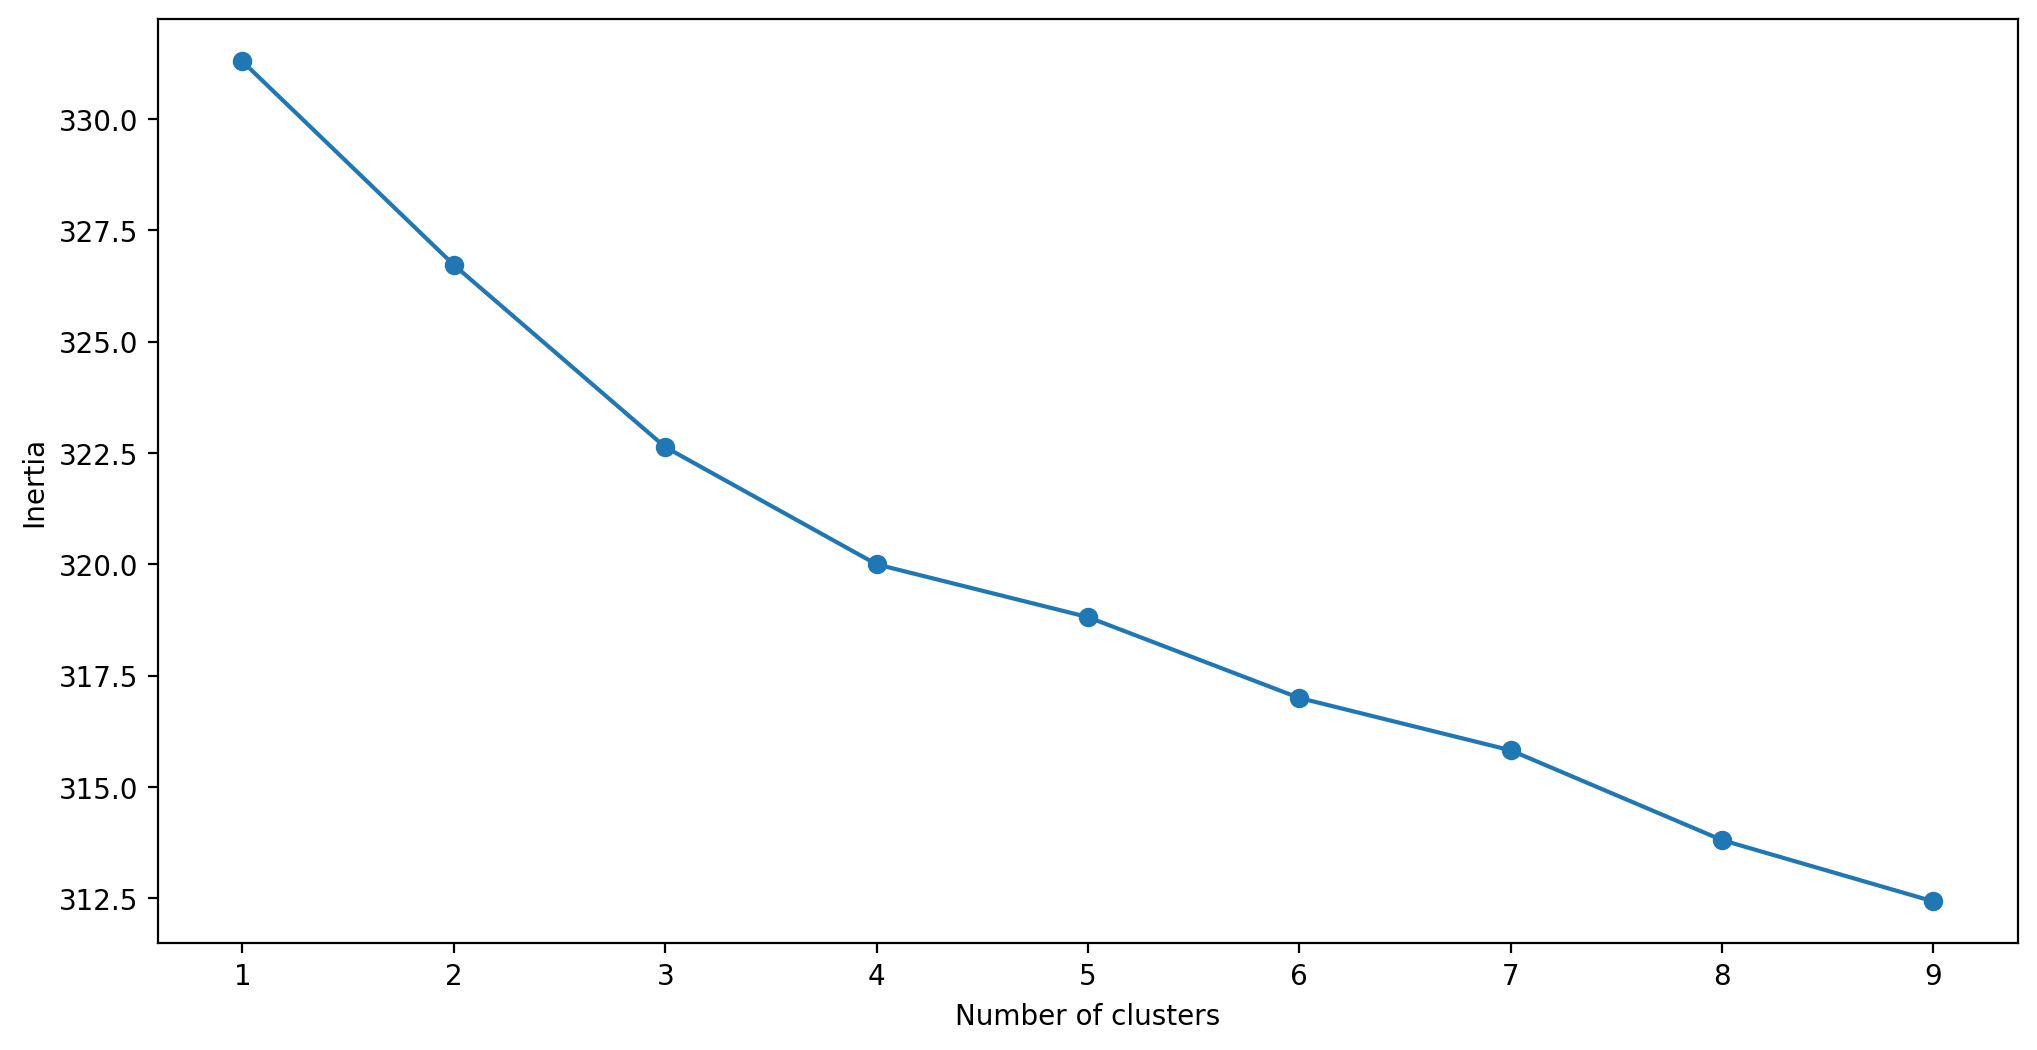

In [13]:
# Assuming rang_cluster and SSE are numpy arrays or lists
frame = pd.DataFrame({'Cluster': rang_cluster, 'SSE': SSE})
plt.figure(figsize=(12, 6))
plt.plot(frame['Cluster'].values, frame['SSE'].values, marker='o')  # Convert to numpy arrays
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Clustering using k-means

In [14]:
# Combine relevant columns into a text feature for clustering
text_feature = filtered_df['filtered_Text']   # You can customize this based on your features

# Use TfidfVectorizer to convert text data into a numerical format, removing stopwords
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_feature)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters as needed
filtered_df['cluster'] = kmeans.fit_predict(X)

# Display the DataFrame with cluster assignments
print("DataFrame with cluster assignments:")
print(filtered_df)

DataFrame with cluster assignments:
                                                  Text  Category  \
0    Reports claim that the sweetener aspartame, co...    health   
1    Scientists have discovered a key defense mecha...    health   
2    An appeal has been launched to raise one milli...    health   
3    European Union (EU) officials are strongly rec...    health   
4    Experts have informed the BBC that the current...    health   
..                                                 ...       ...   
335  Rival banking giant HSBC, which is based in Lo...  business   
336  The aid package would "create a positive clima...  business   
337  The IMF stands ready to do its part to assist ...  business   
338  Russia has been waiting for a decade to join t...  business   
339  The country's banking market is three times th...  business   

                                         filtered_Text  cluster  
0    report claim sweetener aspartame commonly foun...        2  
1    scientist 

In [15]:
df['cluster'].value_counts()

cluster
2    139
1    113
0     88
Name: count, dtype: int64

In [16]:
for cluster_num in range(filtered_df['cluster'].nunique()):
    cluster_description = filtered_df[filtered_df['cluster'] == cluster_num]['filtered_Text']

    print(f'\nCluster {cluster_num} filtered_Text:')
    print(cluster_description.values)



Cluster 0 filtered_Text:
['scientist discover key defense mechanism effectively block majority bird flu strain invade body bird flu cause four pandemic since result million death researcher university glasgow found pandemic along regular winter flu evolve strategy bypass natural defense barrier the team believe soon able predict bird flu strain pose great risk the scientist conduct investigation spillover event occur person becomes infect animal this cross specie transmission critical step emergence new pandemic through laboratory experiment researcher identify specific section dna call btna becomes activate response infection btna found active nose throat lung reduce ability bird flu strain replicate dr rute maria pinto one researcher state nearly all bird flu strain unable bypass protective mechanism therefore can not infect human however human virus include pandemic strain evolve resistance btna overcome defense barrier there ongoing risk bird flu strain cross human wild bird harbo

In [17]:
# Create a mapping for cluster names
cluster_names_mapping = {0: 'health', 1: 'sport', 2: 'business'}

# Map cluster numbers to names
filtered_df['cluster_name'] = filtered_df['cluster'].map(cluster_names_mapping)

filtered_df

,Text,Category,filtered_Text,cluster,cluster_name
0,"Reports claim that the sweetener aspartame, co...",health,report claim sweetener aspartame commonly foun...,2,business
1,Scientists have discovered a key defense mecha...,health,scientist discover key defense mechanism effec...,0,health
2,An appeal has been launched to raise one milli...,health,an appeal launch raise one million pound leuka...,0,health
3,European Union (EU) officials are strongly rec...,health,european union eu official strongly recommend ...,0,health
4,Experts have informed the BBC that the current...,health,expert inform bbc current surge covid case chi...,0,health
...,...,...,...,...,...
335,"Rival banking giant HSBC, which is based in Lo...",business,rival banking giant hsbc base london hong kong...,2,business
336,"The aid package would ""create a positive clima...",business,the aid package would create positive climate ...,2,business
337,The IMF stands ready to do its part to assist ...,business,the imf stand ready part assist nation appropr...,2,business
338,Russia has been waiting for a decade to join t...,business,russia wait decade join wto hope finally becom...,2,business


In [18]:
filtered_df['category_old'] = filtered_df['Category'].map({'business':1,'sport':2,'health':0})
filtered_df

,Text,Category,filtered_Text,cluster,cluster_name,category_old
0,"Reports claim that the sweetener aspartame, co...",health,report claim sweetener aspartame commonly foun...,2,business,0
1,Scientists have discovered a key defense mecha...,health,scientist discover key defense mechanism effec...,0,health,0
2,An appeal has been launched to raise one milli...,health,an appeal launch raise one million pound leuka...,0,health,0
3,European Union (EU) officials are strongly rec...,health,european union eu official strongly recommend ...,0,health,0
4,Experts have informed the BBC that the current...,health,expert inform bbc current surge covid case chi...,0,health,0
...,...,...,...,...,...,...
335,"Rival banking giant HSBC, which is based in Lo...",business,rival banking giant hsbc base london hong kong...,2,business,1
336,"The aid package would ""create a positive clima...",business,the aid package would create positive climate ...,2,business,1
337,The IMF stands ready to do its part to assist ...,business,the imf stand ready part assist nation appropr...,2,business,1
338,Russia has been waiting for a decade to join t...,business,russia wait decade join wto hope finally becom...,2,business,1


In [19]:
filtered_df.cluster_name.value_counts()

cluster_name
business    139
sport       113
health       88
Name: count, dtype: int64

In [20]:
from sklearn.metrics import accuracy_score

# Display the DataFrame with cluster names
print("DataFrame with Cluster Names:")
print(filtered_df[['filtered_Text', 'cluster_name', 'Category']])

# Calculate accuracy
accuracy = accuracy_score(filtered_df['Category'], filtered_df['cluster_name'])

print("Accuracy:", accuracy)

DataFrame with Cluster Names:
                                         filtered_Text cluster_name  Category
0    report claim sweetener aspartame commonly foun...     business    health
1    scientist discover key defense mechanism effec...       health    health
2    an appeal launch raise one million pound leuka...       health    health
3    european union eu official strongly recommend ...       health    health
4    expert inform bbc current surge covid case chi...       health    health
..                                                 ...          ...       ...
335  rival banking giant hsbc base london hong kong...     business  business
336  the aid package would create positive climate ...     business  business
337  the imf stand ready part assist nation appropr...     business  business
338  russia wait decade join wto hope finally becom...     business  business
339  the country s banking market three time size h...     business  business

[340 rows x 3 columns]
Accuracy: 

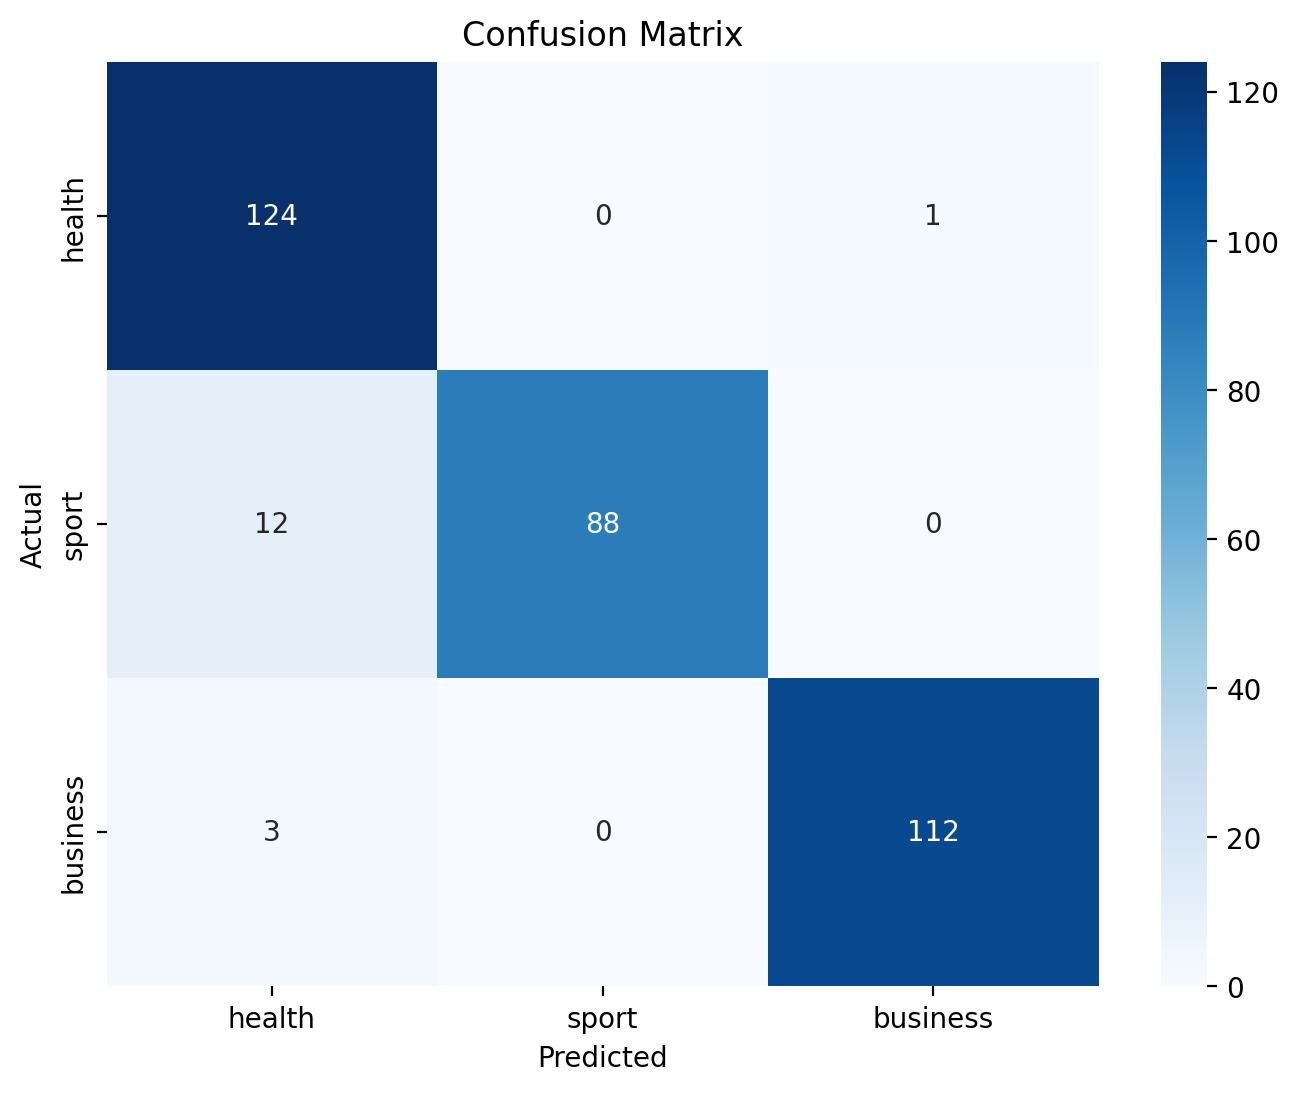

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Create confusion matrix
conf_matrix = confusion_matrix(filtered_df['Category'], filtered_df['cluster_name'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cluster_names_mapping.values(), yticklabels=cluster_names_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score
target_names=['health','business','sport']
print(classification_report(y_pred=df['cluster'],y_true=df['category_old'],target_names=target_names))

              precision    recall  f1-score   support

      health       1.00      0.88      0.94       100
    business       0.01      0.01      0.01       125
       sport       0.02      0.03      0.02       115

    accuracy                           0.27       340
   macro avg       0.34      0.30      0.32       340
weighted avg       0.30      0.27      0.29       340



## prediction and GUI

In [34]:
import tkinter as tk
from tkinter import ttk
import csv

def preprocess_text(text):
    # Add your preprocessing steps here
    return text

def predict_cluster_with_name(new_text):
    """
    Predicts the cluster name for a new text.

    Args:
    new_text (str): The new text to be predicted.

    Returns:
    tuple: A tuple containing the predicted cluster number and its corresponding name.
    """
    # Preprocess the new text
    preprocessed_text = preprocess_text(new_text)

    # Vectorize the preprocessed text using the same vectorizer
    vectorized_text = vectorizer.transform([preprocessed_text])

    # Predict the cluster of the vectorized text
    predicted_cluster = kmeans.predict(vectorized_text)[0]

    # Map the predicted cluster number to its name
    predicted_cluster_name = cluster_names_mapping[predicted_cluster]

    return predicted_cluster, predicted_cluster_name

def predict_and_display():
    """
    Predicts the cluster for the new text and displays the result.
    Appends the result to the CSV file.
    """
    new_text = new_text_entry.get()
    if new_text:
        predicted_cluster, predicted_cluster_name = predict_cluster_with_name(new_text)
        result_label.config(text=f"Predicted Cluster: {predicted_cluster}\nPredicted Cluster Name: {predicted_cluster_name}")

        # Append the result to the CSV file
        with open('news_data.csv', 'a', newline='') as csvfile:
            fieldnames = ['Text', 'Predicted Cluster', 'Predicted Cluster Name']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({'Text': new_text, 'Predicted Cluster': predicted_cluster, 'Predicted Cluster Name': predicted_cluster_name})
    else:
        result_label.config(text="Please enter some text.")

# Create Tkinter application window
root = tk.Tk()
root.title("Text Clustering Prediction")

# Create input field for new text with increased width
new_text_label = ttk.Label(root, text="Enter New Text:")
new_text_label.pack(pady=5)
new_text_entry = ttk.Entry(root, width=60)  # Increased width
new_text_entry.pack(pady=10)

# Create button to trigger prediction
predict_button = ttk.Button(root, text="Predict", command=predict_and_display)
predict_button.pack(pady=5)

# Create label to display result
result_label = ttk.Label(root, text="")
result_label.pack(pady=5)

# Run the Tkinter event loop
root.mainloop()
